## Installing Dependencies

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import glob
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/delhi-air-quality-dataset/final_dataset.csv


## Configuration & Initial Data Processing

In [2]:
TARGET_COL = "AQI"
FORECAST_HORIZON = 48
LAG_HOURS = 72
ROLL_WINDOWS = [3, 6, 12, 24]

VAL_DAYS = 5
TEST_DAYS = 7

SEED = 42
np.random.seed(SEED)

# Load CSV
csv_path = "/kaggle/input/delhi-air-quality-dataset/final_dataset.csv"
print("Using:", csv_path)
df = pd.read_csv(csv_path)
df.head(5)

Using: /kaggle/input/delhi-air-quality-dataset/final_dataset.csv


,Date,Month,Year,Holidays_Count,Days,PM2.5,PM10,NO2,SO2,CO,Ozone,AQI
0,1,1,2021,0,5,408.80,442.42,160.61,12.95,2.77,43.19,462
1,2,1,2021,0,6,404.04,561.95,52.85,5.18,2.60,16.43,482
2,3,1,2021,1,7,225.07,239.04,170.95,10.93,1.40,44.29,263
3,4,1,2021,0,1,89.55,132.08,153.98,10.42,1.01,49.19,207
4,5,1,2021,0,2,54.06,55.54,122.66,9.70,0.64,48.88,149


In [3]:
# Construct proper datetime from Year, Month, Date columns
df["ds"] = pd.to_datetime(df["Year"].astype(str) + "-" +
                          df["Month"].astype(str) + "-" +
                          df["Date"].astype(str),
                          format="%Y-%m-%d",
                          errors="coerce")

df = df.dropna(subset=["ds"]).sort_values("ds").reset_index(drop=True)

In [4]:
# Target column check
if TARGET_COL not in df.columns:
    for c in df.columns:
        if "pm2.5" in c.lower() or "pm25" in c.lower():
            TARGET_COL = c
            break

df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")
df = df.dropna(subset=[TARGET_COL])

# Dataset is already hourly — ensure sorted and clean
df = df.sort_values("ds").reset_index(drop=True)

## Exploratory Data Analysis

In [5]:
print("\nEDA: Basic Info")
print(df.info())

print("\nEDA: First Datapoints")
print(df.head())


EDA: Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1461 non-null   int64         
 1   Month           1461 non-null   int64         
 2   Year            1461 non-null   int64         
 3   Holidays_Count  1461 non-null   int64         
 4   Days            1461 non-null   int64         
 5   PM2.5           1461 non-null   float64       
 6   PM10            1461 non-null   float64       
 7   NO2             1461 non-null   float64       
 8   SO2             1461 non-null   float64       
 9   CO              1461 non-null   float64       
 10  Ozone           1461 non-null   float64       
 11  AQI             1461 non-null   int64         
 12  ds              1461 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(6)
memory usage: 148.5 KB
None

EDA: First Datapoin

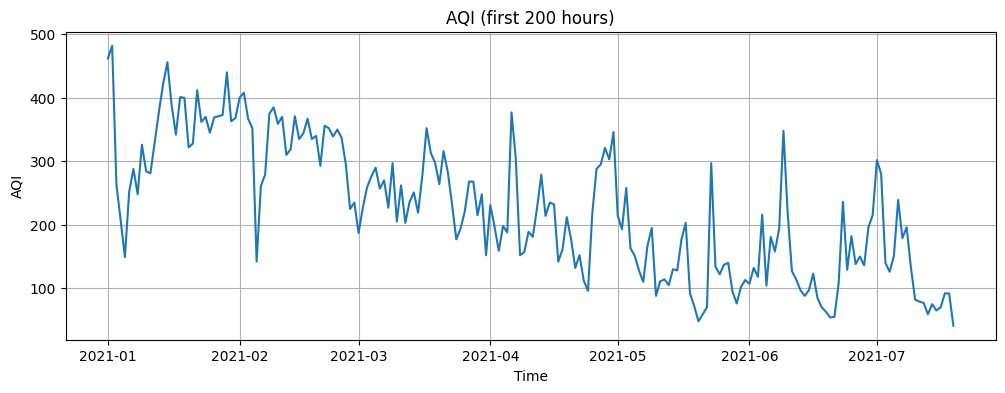

In [6]:
plt.figure(figsize=(12,4))
plt.plot(df["ds"].head(200), df[TARGET_COL].head(200))
plt.title("AQI (first 200 hours)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid(True)
plt.show()

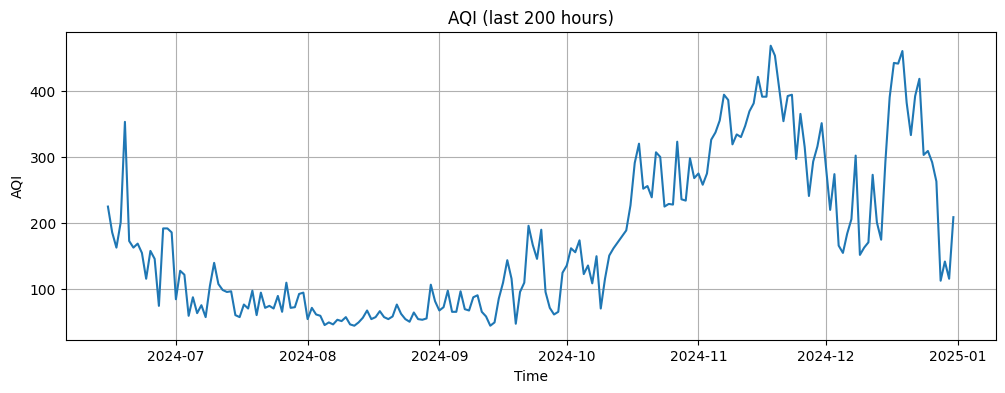

In [7]:
plt.figure(figsize=(12,4))
plt.plot(df["ds"].tail(200), df[TARGET_COL].tail(200))
plt.title("AQI (last 200 hours)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid(True)
plt.show()

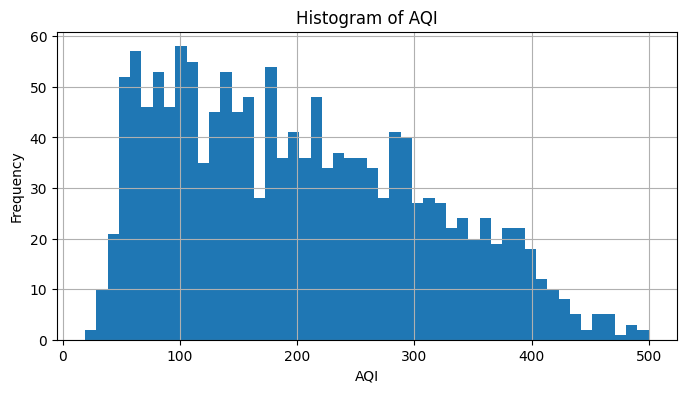

In [8]:
plt.figure(figsize=(8,4))
plt.hist(df[TARGET_COL], bins=50)
plt.title("Histogram of AQI")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

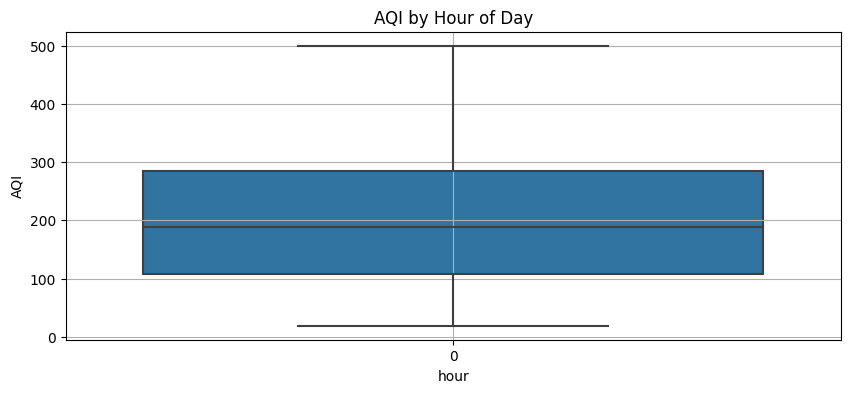

In [9]:
import seaborn as sns
df["hour"] = df["ds"].dt.hour
plt.figure(figsize=(10,4))
sns.boxplot(x="hour", y=TARGET_COL, data=df)
plt.title("AQI by Hour of Day")
plt.grid(True)
plt.show()

invalid value encountered in less


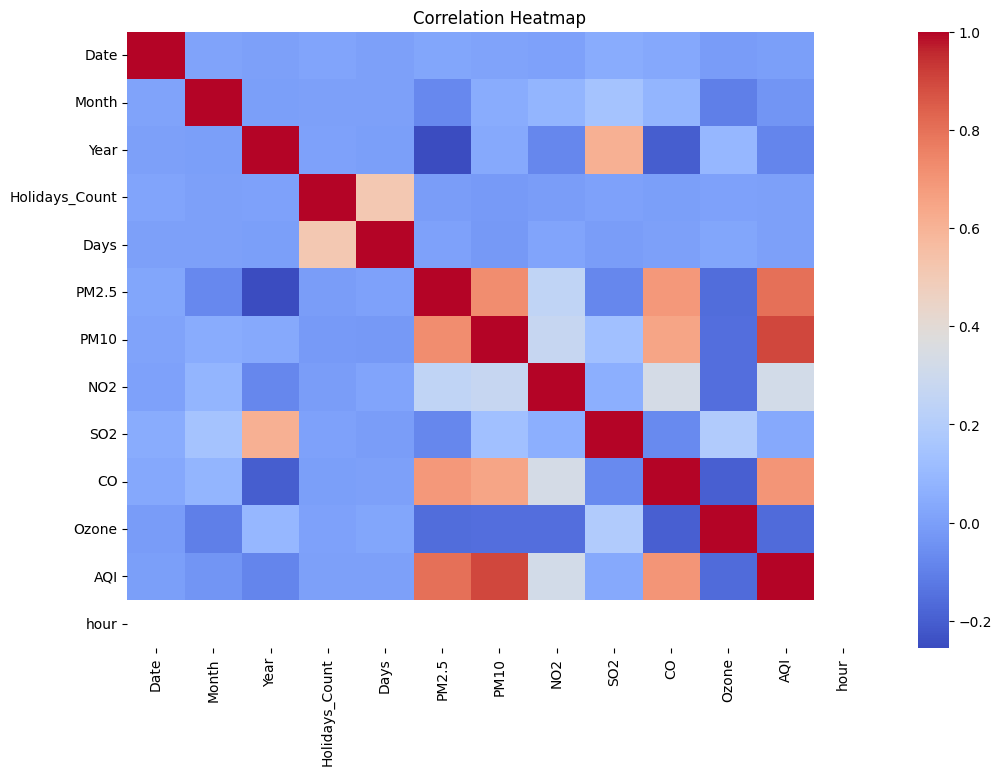

In [10]:
# Correlation heatmap (for numeric columns)
num_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

## Feature Engineering

In [11]:
df["dayofweek"] = df["ds"].dt.dayofweek
df["day"] = df["ds"].dt.day
df["month"] = df["ds"].dt.month

for lag in range(1, LAG_HOURS + 1):
    df[f"{TARGET_COL}_lag_{lag}"] = df[TARGET_COL].shift(lag)

for w in ROLL_WINDOWS:
    df[f"{TARGET_COL}_roll_{w}"] = df[TARGET_COL].rolling(w).mean()

df = df.dropna().reset_index(drop=True)

## Splitting Dataset

Dataset is split into Train, Test, Val. <br>
- **Test:** Data from the last 7 days
- **Val:** Data from previous 5 days (before the last week)
- **Train:** Everything Else

In [12]:
latest = df["ds"].max()
val_start = latest - timedelta(days=TEST_DAYS + VAL_DAYS)
test_start = latest - timedelta(days=TEST_DAYS)

train_df = df[df["ds"] <= val_start].copy()
val_df = df[(df["ds"] > val_start) & (df["ds"] <= test_start)].copy()
test_df = df[df["ds"] > test_start].copy()

features = [c for c in df.columns if c not in ["ds", TARGET_COL]]

scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

X_train = train_df[features].values
y_train = train_df[TARGET_COL].values

X_val = val_df[features].values
y_val = val_df[TARGET_COL].values

## Model Training and Fine-Tuning

### Hyperparameter Tuning (Using Optuna)

In [13]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "max_depth": trial.suggest_int("max_depth", 4, 14),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 3.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "random_state": SEED
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    preds = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, preds))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)

[I 2025-11-15 14:19:35,090] A new study created in memory with name: no-name-a37e4b26-8e9a-4f01-8279-1e777b0b1161
[I 2025-11-15 14:19:37,782] Trial 0 finished with value: 16.71490962986579 and parameters: {'n_estimators': 865, 'max_depth': 6, 'learning_rate': 0.08396914226089464, 'subsample': 0.5656930506031799, 'colsample_bytree': 0.7363078026494394, 'gamma': 1.8258754971498805, 'min_child_weight': 9}. Best is trial 0 with value: 16.71490962986579.
[I 2025-11-15 14:19:41,478] Trial 1 finished with value: 21.359338781618938 and parameters: {'n_estimators': 375, 'max_depth': 12, 'learning_rate': 0.08398889934730601, 'subsample': 0.9898374599585935, 'colsample_bytree': 0.5919797822471897, 'gamma': 0.952689522959702, 'min_child_weight': 1}. Best is trial 0 with value: 16.71490962986579.
[I 2025-11-15 14:19:42,845] Trial 2 finished with value: 25.49215447284948 and parameters: {'n_estimators': 477, 'max_depth': 4, 'learning_rate': 0.17754063515311116, 'subsample': 0.7682542255826958, 'cols

Best parameters: {'n_estimators': 835, 'max_depth': 13, 'learning_rate': 0.1802398206537331, 'subsample': 0.898640284885416, 'colsample_bytree': 0.9674222960153216, 'gamma': 2.853584761583474, 'min_child_weight': 3}


### Final Model Training

In [14]:
# Using Best Parameters from Hyperparameter Tuning
best_params = study.best_params
best_params.update({
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "random_state": SEED
})

model = xgb.XGBRegressor(**best_params)
model.fit(train_df[features], train_df[TARGET_COL])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9674222960153216, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.853584761583474,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1802398206537331,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=835, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Feature Importance from XGBoost

       feature     importance
86  AQI_roll_3  111301.273438
6         PM10   21849.960938
5        PM2.5    3356.484375
9           CO     905.080261
76  AQI_lag_63     826.164062
53  AQI_lag_40     798.134583
10       Ozone     770.280640
15   AQI_lag_2     726.508301
75  AQI_lag_62     713.603271
35  AQI_lag_22     558.468506
22   AQI_lag_9     546.010376
68  AQI_lag_55     486.864044
7          NO2     462.319061
72  AQI_lag_59     400.740265
84  AQI_lag_71     357.549957
59  AQI_lag_46     343.306519
46  AQI_lag_33     339.611633
32  AQI_lag_19     335.067230
51  AQI_lag_38     335.001831
40  AQI_lag_27     330.821320


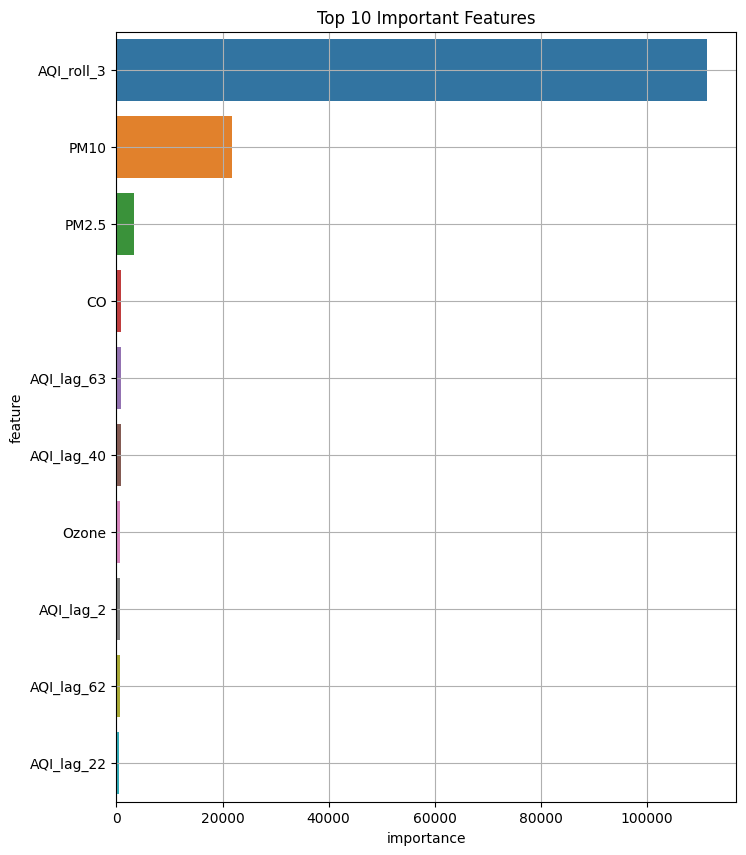

In [15]:
importance = model.get_booster().get_score(importance_type='gain')
fi_df = pd.DataFrame({
    "feature": list(importance.keys()),
    "importance": list(importance.values())
}).sort_values("importance", ascending=False)

print(fi_df.head(20))

plt.figure(figsize=(8,10))
sns.barplot(data=fi_df.head(10), x="importance", y="feature")
plt.title("Top 10 Important Features")
plt.grid(True)
plt.show()

## Evaluation on Test Set

Test MAE: 27.037303379603795
Test RMSE: 32.63151620782507
MAPE (%): 16.87465454513643
Accuracy (%): 83.12534545486358


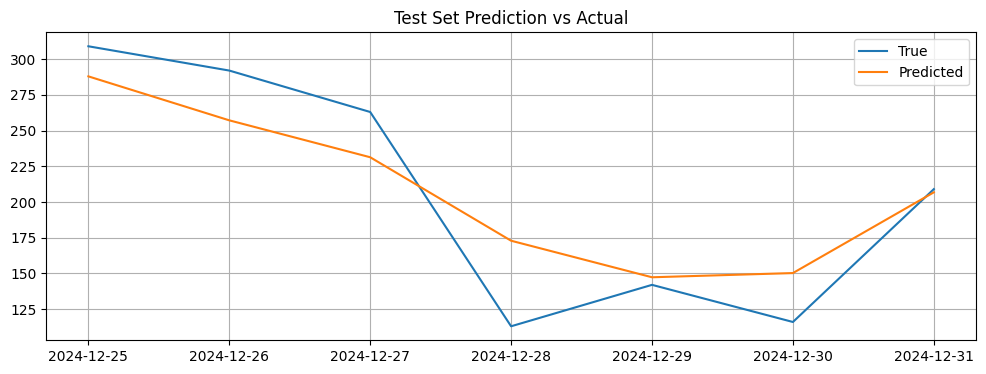

In [16]:
X_test = test_df[features].values
y_test = test_df[TARGET_COL].values

y_pred = model.predict(X_test)

epsilon = 1e-10 # Avoid division by zero by adding a very small epsilon
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
accuracy = 100 - mape

print("Test MAE:", mae)
print("Test RMSE:", rmse)
print("MAPE (%):", mape)
print("Accuracy (%):", accuracy)

plt.figure(figsize=(12,4))
plt.plot(test_df["ds"], y_test, label="True")
plt.plot(test_df["ds"], y_pred, label="Predicted")
plt.title("Test Set Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

## Forecast for the Next 48 Hours

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale


Next 48h forecast:
             timestamp  predicted_AQI
0  2024-12-31 01:00:00     208.619049
1  2024-12-31 02:00:00     196.600250
2  2024-12-31 03:00:00     192.896072
3  2024-12-31 04:00:00     191.750717
4  2024-12-31 05:00:00     209.144592
5  2024-12-31 06:00:00     211.025970
6  2024-12-31 07:00:00     221.250488
7  2024-12-31 08:00:00     221.372314
8  2024-12-31 09:00:00     228.734070
9  2024-12-31 10:00:00     228.446976
10 2024-12-31 11:00:00     228.534927
11 2024-12-31 12:00:00     227.261932
12 2024-12-31 13:00:00     220.478210
13 2024-12-31 14:00:00     234.011658
14 2024-12-31 15:00:00     230.912827
15 2024-12-31 16:00:00     230.561066
16 2024-12-31 17:00:00     228.360931
17 2024-12-31 18:00:00     225.561493
18 2024-12-31 19:00:00     226.798080
19 2024-12-31 20:00:00     228.349350
20 2024-12-31 21:00:00     228.308929
21 2024-12-31 22:00:00     235.913742
22 2024-12-31 23:00:00     225.037262
23 2025-01-01 00:00:00     229.100800
24 2025-01-01 01:00:00     242

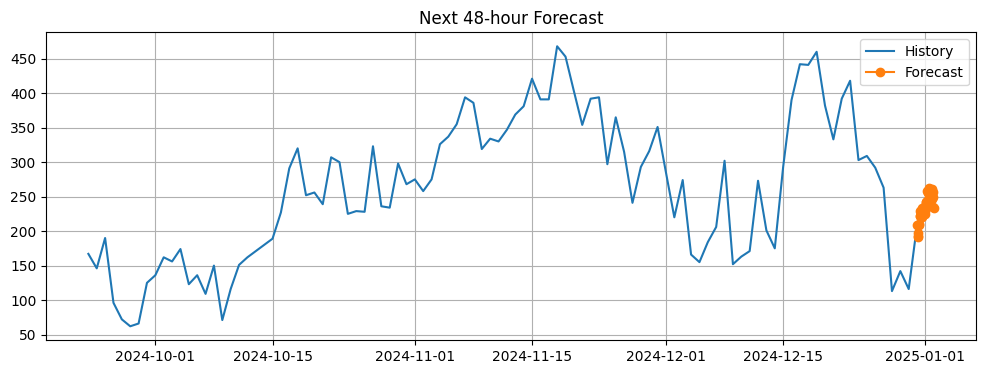

In [17]:
# (recursive)
last_row = df.iloc[-1:].copy()
future_predictions = []
future_times = []

current_time = df["ds"].max()
current_row = last_row.copy()

for step in range(1, FORECAST_HORIZON + 1):
    current_time += timedelta(hours=1)
    future_times.append(current_time)

    for lag in range(LAG_HOURS, 1, -1):
        curr = f"{TARGET_COL}_lag_{lag}"
        prev = f"{TARGET_COL}_lag_{lag-1}"
        current_row[curr] = current_row[prev]

    current_row[f"{TARGET_COL}_lag_1"] = (
        future_predictions[-1] if len(future_predictions) > 0 else last_row[TARGET_COL].values[0]
    )

    for w in ROLL_WINDOWS:
        vals = [current_row[f"{TARGET_COL}_lag_{lag}"].values[0] for lag in range(1, w+1)]
        current_row[f"{TARGET_COL}_roll_{w}"] = np.mean(vals)

    current_row["hour"] = current_time.hour
    current_row["dayofweek"] = current_time.dayofweek
    current_row["day"] = current_time.day
    current_row["month"] = current_time.month

    temp = current_row[features].values
    temp = scaler.transform(temp)

    pred = model.predict(temp)[0]
    future_predictions.append(pred)

forecast_df = pd.DataFrame({
    "timestamp": future_times,
    "predicted_AQI": future_predictions
})

print("\nNext 48h forecast:")
print(forecast_df)

plt.figure(figsize=(12,4))
plt.plot(df.tail(100)["ds"], df.tail(100)[TARGET_COL], label="History")
plt.plot(future_times, future_predictions, marker="o", label="Forecast")
plt.title("Next 48-hour Forecast")
plt.grid(True)
plt.legend()
plt.show()